In [1]:
#导入必须的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

plt.style.use('fivethirtyeight')#画图风格
np.random.seed(100)

window=31 #时间窗   test集 的數據量 
label_dim=60 #标签纬度
scale=100 #归一化参数
amount_of_features=1 #特征数量
d=0.05 #dropout系数
batch_size=12 #批训练数量
epoch=200 #总迭代次数

train_file='2015_2018_train.csv' #读取训练集地址
test_file='2015_2018_test.csv' #读取測試集地址
save_file='2015_2018_predict.csv' #储存预测值地址

In [15]:
data=pd.read_csv(train_file,header=0) 
data=data['BR13']#选数据集的哪一列

#构造针对机器学习模型的数据集
data=data.values 
dataset=data
for i in range(window+label_dim-1): #類似shift()概念
    zero=np.zeros(i+1) #生成一個元素為 i+1 個 0 的一維矩陣
    temp=np.append(data[i+1:],zero) #NumPy 陣列追加，(arr:要新增元素的陣列,values:被新增陣列, axis = None)
    dataset=np.row_stack((dataset,temp)) #行合併  
dataset=pd.DataFrame(dataset).T #轉置資料
dataset=dataset.iloc[:-(window+label_dim)] #倒數window+label_dim之前的行數據
#dataset=dataset/scale #进行伪归一化
print(dataset)

"""
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(dataset,annot=False)
plt.show()#展示下原始数据集
"""

           0        1        2        3        4        5        6        7   \
0     10830.0  10399.0  12094.0  11503.0  12033.0  13083.0   9842.0    106.0   
1     10399.0  12094.0  11503.0  12033.0  13083.0   9842.0    106.0  10209.0   
2     12094.0  11503.0  12033.0  13083.0   9842.0    106.0  10209.0  12794.0   
3     11503.0  12033.0  13083.0   9842.0    106.0  10209.0  12794.0  12316.0   
4     12033.0  13083.0   9842.0    106.0  10209.0  12794.0  12316.0  12429.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1122  12474.0  11952.0  11545.0  11345.0  12809.0   9425.0   9412.0  12366.0   
1123  11952.0  11545.0  11345.0  12809.0   9425.0   9412.0  12366.0  11428.0   
1124  11545.0  11345.0  12809.0   9425.0   9412.0  12366.0  11428.0  11697.0   
1125  11345.0  12809.0   9425.0   9412.0  12366.0  11428.0  11697.0  11662.0   
1126  12809.0   9425.0   9412.0  12366.0  11428.0  11697.0  11662.0  13427.0   

           8        9   ...       81   

'\nimport seaborn as sns\nplt.figure(figsize=(10,5))\nsns.heatmap(dataset,annot=False)\nplt.show()#展示下原始数据集\n'

In [3]:
#划分特征与标签
X=dataset.iloc[:,:window]
y=dataset.iloc[:,-label_dim:]

In [4]:
#构造训练集测试集
X,y=X.values,y.values
print(X.shape)#通过输出训练集测试集的大小来判断数据格式正确。
print(y.shape)

(1127, 31)
(1127, 60)


In [5]:
#LSTM神经网络的数据集要稍微做一些修改
X= np.reshape(X, (X.shape[0],X.shape[1], amount_of_features))
print(X.shape)
print(y.shape)

(1127, 31, 1)
(1127, 60)


In [6]:
#建立LSTM模型 训练
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Dropout
from keras.layers.recurrent import LSTM
#建立训练模型过程
model = Sequential()#建立层次模型
model.add(LSTM(32, input_shape=(window, amount_of_features), return_sequences=False))#建立LSTM层
#model.add(Dropout(d))
model.add(Dense(label_dim*2,activation='relu'))   #建立全连接层  
#model.add(Dropout(d))
model.add(Dense(label_dim))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()

Using TensorFlow backend.
F:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
F:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
F:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
F:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 120)               3960      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                7260      
Total params: 15,572
Trainable params: 15,572
Non-trainable params: 0
_________________________________________________________________


In [7]:
#神经网络训练及结果
history = model.fit(X, y, epochs =epoch, batch_size = batch_size,verbose=1,validation_split=0.1) #训练模型nb_epoch次


Train on 1014 samples, validate on 113 samples
Epoch 1/200
1014/1014 [==============================] - 1s 1ms/step - loss: 11939.5435 - accuracy: 0.0197 - val_loss: 10671.1534 - val_accuracy: 0.0177
Epoch 2/200
1014/1014 [==============================] - 1s 572us/step - loss: 5987.8766 - accuracy: 0.0118 - val_loss: 2344.0904 - val_accuracy: 0.0177
Epoch 3/200
1014/1014 [==============================] - 1s 575us/step - loss: 668.9889 - accuracy: 0.0138 - val_loss: 200.9397 - val_accuracy: 0.0177
Epoch 4/200
1014/1014 [==============================] - 1s 575us/step - loss: 217.8129 - accuracy: 0.0118 - val_loss: 195.8071 - val_accuracy: 0.0177
Epoch 5/200
1014/1014 [==============================] - 1s 574us/step - loss: 216.7515 - accuracy: 0.0128 - val_loss: 197.2564 - val_accuracy: 0.0088
Epoch 6/200
1014/1014 [==============================] - 1s 582us/step - loss: 216.5108 - accuracy: 0.0187 - val_loss: 196.7474 - val_accuracy: 0.0088
Epoch 7/200
1014/1014 [===================

Epoch 107/200
1014/1014 [==============================] - 1s 659us/step - loss: 169.4601 - accuracy: 0.0651 - val_loss: 134.5468 - val_accuracy: 0.0442
Epoch 108/200
1014/1014 [==============================] - 1s 629us/step - loss: 168.6353 - accuracy: 0.0631 - val_loss: 132.1552 - val_accuracy: 0.0354
Epoch 109/200
1014/1014 [==============================] - 1s 610us/step - loss: 169.1665 - accuracy: 0.0621 - val_loss: 136.1219 - val_accuracy: 0.0354
Epoch 110/200
1014/1014 [==============================] - 1s 656us/step - loss: 168.4500 - accuracy: 0.0631 - val_loss: 133.2127 - val_accuracy: 0.0177
Epoch 111/200
1014/1014 [==============================] - 1s 629us/step - loss: 168.4805 - accuracy: 0.0690 - val_loss: 128.3105 - val_accuracy: 0.0442
Epoch 112/200
1014/1014 [==============================] - 1s 580us/step - loss: 167.4821 - accuracy: 0.0690 - val_loss: 138.7321 - val_accuracy: 0.0442
Epoch 113/200
1014/1014 [==============================] - 1s 571us/step - loss: 1

In [8]:
#筛选测试集
test=pd.read_csv(test_file,header=0) 
test=test['BR13']/scale#选数据集的哪一列
test=np.reshape(test.values, (1, window,amount_of_features))
print(test.shape)

(1, 31, 1)


In [9]:
#实际预测
predict=model.predict(test)[0,:]*scale
#储存文件
(pd.DataFrame(predict)).to_csv(save_file)
print(predict)

[10778.678  10690.497  11680.517  12129.009   9833.455   9463.409
 10743.772  10828.37   10795.058  11656.5205 12000.239   9758.08
  9419.618  10756.14   10830.445  10789.087  11713.359  12279.605
  9811.687   9452.056  10748.764  10961.502  10968.821  11786.392
 12214.463   9768.38    9356.861  10736.296  10985.387  10898.302
 11760.448  12182.382   9953.899   9681.711  10884.426  10971.121
 10838.906  11829.831  12183.35    9901.923   9689.915  10965.579
 11044.126  10946.463  11705.549  12128.804   9982.386   9762.443
 11027.152  11124.764  10898.448  11802.471  12293.806   9967.869
  9681.745  10978.888  11080.784  10981.804  11910.311  12412.452 ]


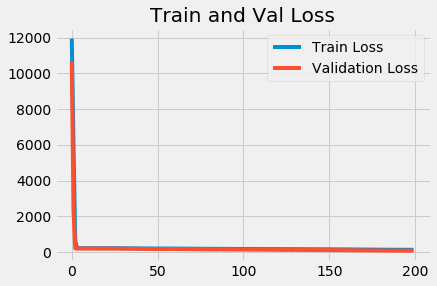

In [10]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

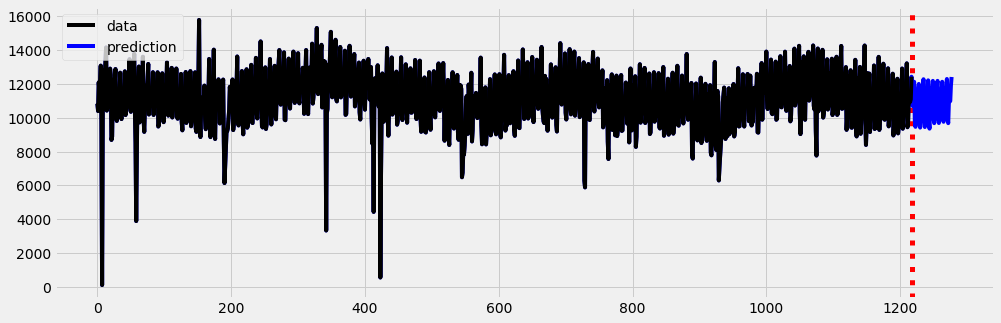

In [11]:
data_times=np.arange(len(data)) #np.arange(起始,終點,間距)
all_data=np.hstack((data,predict)) #np.hstack 沿著水準方向將陣列堆疊起來
predicted_times=np.arange(len(all_data))

plt.figure(figsize=(15, 5))
plt.axvline(len(data), linestyle="dotted", linewidth=5, color='r') #axvline 畫垂直線
predicted_lines = plt.plot(predicted_times, all_data, label="prediction", color="b")
data_lines = plt.plot(data_times, data, label="data", color="k")
plt.legend(handles=[data_lines[0], predicted_lines[0]],loc="upper left")
#为训练，验证，预测数据分别创建图例
plt.show()